<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/neuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Установка зависимостей

!pip install pywavelets pyxdf mne numpy scipy pandas git+https://github.com/alena-kono/NeuroKit.git@6304093b

  Cloning https://github.com/alena-kono/NeuroKit.git (to revision 6304093b) to /tmp/pip-req-build-tost__6x
  Running command git clone --filter=blob:none --quiet https://github.com/alena-kono/NeuroKit.git /tmp/pip-req-build-tost__6x
  Running command git checkout -q 6304093b
  Resolved https://github.com/alena-kono/NeuroKit.git to commit 6304093b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.7 MB/s eta 0:00:00
  Created wheel for neurokit2: filename=neurokit2-0.2.6-py2.py3-none-any.whl size=1280788 sha256=6931733ebd7287e0c8b2baf8512608220b51cf09c2df1ea45b8d6722df489ed9
  Stored in directory: /tmp/pip-ephem-wheel-cache-lazkcl_7/wheels/6e/a6/aa/aa034c5f3e1ab3e60eb7adb8e9dd3e5e1de9e78711b33c51f7
Successfully built neurokit2


In [2]:
## Импорт зависимостей

import mne
import enum
import pyxdf
import pywt
import numpy as np
import pandas as pd
import statistics
from google.colab import drive
import matplotlib.pyplot as plt

In [4]:
## Загрузка и предобработка файла .xdf
## При первом запуске гугл попросит доступ в гугл диск, нужно авторизоваться в нем
## Далее нужно загрузить файл Protocol-1.xdf в папку /content/gdrive/MyDrive/Files
## При изменении названия файла нужно поменять переменную filename

## Важно запускать все строки сразу через "Среда выполнения" -> "Выполнить все" либо "Shift" + "F9".
## Это необходимо так как некоторые параметры в течение выполнения удаляются и запустить отдельно блок нет возможности.

## Этот скрипт дает такие же показатели как и в neuro.inschooltech.ru

filename = 'EEG_cognitive' ## <- Тут нужно поменять при изменении названия файла.
drive.mount('/content/drive')
streams_for_analysis = [{"type": "Samples"}, {"type": "Responses"}, {"type": "EEG"}]
streams_data = pyxdf.load_xdf('/content/drive/MyDrive/edf_process/' + filename + '.xdf')[0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from __future__ import annotations

import dataclasses
import enum
import typing as tp

import mne
import pandas as pd

XdfData = tuple[list[dict[str, tp.Any]], dict[str, tp.Any]]
StreamDataDict = dict[str, tp.Any]

TIMESTAMP_DECIMAL_PRECISION: int = 4
TIMESTAMP_TOLERANCE_SECS: int = 2

def convert_float_series_to_int(
    timestamp_series: pd.Series,
    decimal_precision: int,
) -> pd.Series:
    return (timestamp_series * (10**decimal_precision)).astype(int)


CHANNEL_TYPES: set[str] = {
    "grad",
    "mag",
    "ref_meg",
    "eeg",
    "seeg",
    "dbs",
    "ecog",
    "eog",
    "emg",
    "ecg",
    "resp",
    "bio",
    "misc",
    "stim",
    "exci",
    "syst",
    "ias",
    "gof",
    "dipole",
    "chpi",
    "fnirs_cw_amplitude",
    "fnirs_fd_ac_amplitude",
    "fnirs_fd_phase",
    "fnirs_od",
    "hbo",
    "hbr",
    "csd",
    "temperature",
    "gsr",
    "eyegaze",
    "pupil",
}


@dataclasses.dataclass(frozen=True)
class Channel:
    name: str
    unit: str
    type_: str = ""


@dataclasses.dataclass(frozen=True)
class ChannelCollection:
    items: list[Channel]

    @classmethod
    def from_stream_data(cls, stream_data: StreamDataDict) -> ChannelCollection:
        channels = []
        for channel_info in stream_data["info"]["desc"][0]["channels"][0]["channel"]:
            name, unit, type_ = (
                channel_info["label"][0],
                channel_info["unit"][0],
                channel_info["type"][0],
            )
            if type_.lower() not in CHANNEL_TYPES:
                type_ = "misc"
            channel = Channel(name=str(name), unit=str(unit), type_=type_)
            channels.append(channel)
        return ChannelCollection(items=channels)

    def get_names(self, to_lower_case: bool) -> list[str]:
        if to_lower_case:
            return [channel.name.lower() for channel in self.items]
        return [channel.name for channel in self.items]


class StreamType(str, enum.Enum):
    # Original case is preserved here as it's a typical setup.
    SAMPLES: str = "Samples"
    RESPONSES: str = "Responses"
    EEG: str = "EEG"
    # These streams are not supported as
    # we don't need them for cognitive functions analysis.
    # MARKERS: str = "markers"

    def to_dict(self) -> dict[str, str]:
        return {"type": self.value}

    @classmethod
    def list_values(cls) -> list[str]:
        stream_type_list: list[StreamType] = list(cls)
        return [stream_type.value for stream_type in stream_type_list]


class BaseStream:
    TIMESTAMP_DECIMAL_PRECISION = TIMESTAMP_DECIMAL_PRECISION
    __slots__ = ("stream_data", "name", "type", "time_series", "time_stamps")

    def __init__(self, stream_data: StreamDataDict) -> None:
        self.stream_data = stream_data
        self.name: str = str(stream_data["info"]["name"][0])
        self.type: str = str(stream_data["info"]["type"][0])
        self._validate_stream_type()
        self.time_series: dict[str, tp.Any] = stream_data["time_series"]
        self.time_stamps: dict[str, tp.Any] = stream_data["time_stamps"]

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(type={self.type})"

    def _validate_stream_type(self) -> None:
        if self.type not in StreamType.list_values():
            raise UnsupportedStreamError(
                f"Stream with type '{self.type}' is not supported"
            )

    def _to_dataframe(
        self,
        time_series_cols: dict[str, tp.Any],
        time_stamps_cols: dict[str, tp.Any],
    ) -> pd.DataFrame:
        series = pd.DataFrame(
            self.time_series,
            columns=list(time_series_cols.keys()),
        )
        stamps = pd.DataFrame(
            self.time_stamps,
            columns=list(time_stamps_cols.keys()),
        )
        dtypes = time_series_cols | time_stamps_cols
        streams_df = series.merge(
            stamps,
            left_index=True,
            right_index=True,
        ).astype(dtypes)
        streams_df["timestamp"] = convert_float_series_to_int(
            timestamp_series=streams_df["timestamp"],
            decimal_precision=self.TIMESTAMP_DECIMAL_PRECISION,
        )
        return streams_df

    def to_dataframe(self) -> pd.DataFrame:
        raise NotImplementedError


class SamplesStream(BaseStream):
    TIME_SERIES_COLS = {
        "response_code": int,
    }
    TIME_STAMPS_COLS = {
        "timestamp": float,
    }

    def __init__(self, stream_data: StreamDataDict) -> None:
        super().__init__(stream_data)

    def to_dataframe(self) -> pd.DataFrame:
        return self._to_dataframe(
            time_series_cols=self.TIME_SERIES_COLS,
            time_stamps_cols=self.TIME_STAMPS_COLS,
        )


class ResponsesStream(BaseStream):
    TIME_SERIES_COLS = {
        "response_code": int,
        "response_value": str,
    }
    TIME_STAMPS_COLS = {
        "timestamp": float,
    }

    def __init__(self, stream_data: StreamDataDict) -> None:
        super().__init__(stream_data)

    def to_dataframe(self) -> pd.DataFrame:
        return self._to_dataframe(
            time_series_cols=self.TIME_SERIES_COLS,
            time_stamps_cols=self.TIME_STAMPS_COLS,
        )


class EEGStream(BaseStream):
    __slots__ = ("channel_count", "nominal_sampling_rate", "channels")
    TIME_SERIES_COLS = {
        "microvolts": float,
    }
    TIME_STAMPS_COLS = {
        "timestamp": float,
    }

    def __init__(self, stream_data: StreamDataDict) -> None:
        super().__init__(stream_data)
        self.channel_count: int = int(stream_data["info"]["channel_count"][0])
        self.nominal_sampling_rate: float = float(
            stream_data["info"]["nominal_srate"][0]
        )
        self.channels: ChannelCollection = ChannelCollection.from_stream_data(
            stream_data
        )

    def to_dataframe(self, channels: list[str] | None = None) -> pd.DataFrame:
        df = self._to_dataframe(
            time_series_cols=self._generate_channels_time_series(),
            time_stamps_cols=self.TIME_STAMPS_COLS,
        )
        if not channels:
            return df
        lower_channels_names = [name.lower() for name in channels]
        return df.loc[:, [*lower_channels_names, "timestamp"]]

    # TODO: Refactor. Validate channels count,
    #  move volts conversion to separate func/method.
    def to_raw(self) -> mne.io.RawArray:
        data = self.stream_data["time_series"].T
        assert data.shape[0] == self.channel_count
        data *= 1e-6
        ch_list = self.channels.get_names(to_lower_case=False)
        ch_types = [ch.type_.lower() for ch in self.channels.items]

        info = mne.create_info(
            ch_names=ch_list, sfreq=self.nominal_sampling_rate, ch_types=ch_types
        )
        return mne.io.RawArray(data, info)

    def _generate_channels_time_series(self) -> dict[str, tp.Any]:
        cols = {}
        col_dtype = self.TIME_SERIES_COLS["microvolts"]
        for channel_name in self.channels.get_names(to_lower_case=True):
            cols[channel_name] = col_dtype
        return cols

In [6]:
## Разбивка .xdf на отдельные стримы данных

def get_streams(streams_data):
    samples_stream, responses_stream, eeg_stream = None, None, None
    for stream in streams_data:
        match str(stream["info"]["type"][0]):
            case "Samples":
                samples_stream = SamplesStream(stream)
            case "Responses":
                responses_stream = ResponsesStream(stream)
            case "EEG":
                eeg_stream = EEGStream(stream)
    streams = (samples_stream, responses_stream, eeg_stream)
    return streams

samples_stream, responses_stream, eeg_stream = get_streams(streams_data)

In [7]:
class CognitionType(enum.Enum):
    COMBINED_FUNCTIONS: str = "COMBINED_FUNCTIONS"
    VISUAL_SEARCH: str = "VISUAL_SEARCH"
    WORKING_MEMORY: str = "WORKING_MEMORY"
    MENTAL_ARITHMETICS: str = "MENTAL_ARITHMETICS"


@dataclasses.dataclass(frozen=True, slots=True, repr=True)
class Event:
    code: int
    action: str
    desc: str

    def is_task_1(self) -> bool:
        return self.action == "task_1"


@dataclasses.dataclass(frozen=True, slots=True, repr=True)
class EventGroup:
    cognition_type: CognitionType
    events: list[Event]

    def flatten(self) -> list[dict[str, int | str]]:
        return [
            dataclasses.asdict(event) | {"cognition_type": self.cognition_type.value}
            for event in self.events
        ]

    def contains_task_1_event(self) -> bool:
        return any([event.is_task_1() for event in self.events])

    def get_user_answer_code_containing_task_1(self) -> int | None:
        contains_task_1_event = self.contains_task_1_event()
        for event in self.events:
            if contains_task_1_event and event.action == "user_answer":
                return event.code
        return None


event_groups = [
    EventGroup(
        cognition_type=CognitionType.COMBINED_FUNCTIONS,
        events=[
            Event(
                code=0,
                action="other",
                desc="rest",
            ),
            Event(
                code=1,
                action="other",
                desc="background_activity",
            ),
            Event(
                code=400,
                action="start",
                desc="start_instruction",
            ),
            Event(
                code=401,
                action="other",
                desc="plus",
            ),
            Event(
                code=402,
                action="task_0",
                desc="matrix",
            ),
            Event(
                code=410,
                action="user_answer",
                desc="user_click",
            ),
        ],
    ),
    EventGroup(
        cognition_type=CognitionType.VISUAL_SEARCH,
        events=[
            Event(
                code=100,
                action="start",
                desc="start_instruction",
            ),
            Event(
                code=101,
                action="other",
                desc="plus",
            ),
            Event(
                code=102,
                action="task_0",
                desc="number",
            ),
            Event(
                code=103,
                action="task_1",
                desc="table",
            ),
            Event(
                code=104,
                action="other",
                desc="black_screen",
            ),
            Event(
                code=110,
                action="user_answer",
                desc="user_click",
            ),
        ],
    ),
    EventGroup(
        cognition_type=CognitionType.WORKING_MEMORY,
        events=[
            Event(
                code=200,
                action="start",
                desc="start_instruction",
            ),
            Event(
                code=201,
                action="other",
                desc="plus",
            ),
            Event(
                code=202,
                action="task_0",
                desc="numbers",
            ),
            Event(
                code=203,
                action="other",
                desc="background_1",
            ),
            Event(
                code=204,
                action="other",
                desc="plus",
            ),
            Event(
                code=205,
                action="task_1",
                desc="number",
            ),
            Event(
                code=206,
                action="other",
                desc="background_2",
            ),
            Event(
                code=210,
                action="user_answer",
                desc="user_click",
            ),
        ],
    ),
    EventGroup(
        cognition_type=CognitionType.MENTAL_ARITHMETICS,
        events=[
            Event(
                code=300,
                action="start",
                desc="start_instruction",
            ),
            Event(
                code=301,
                action="other",
                desc="plus",
            ),
            Event(
                code=302,
                action="task_0",
                desc="equation",
            ),
            Event(
                code=303,
                action="other",
                desc="background_1",
            ),
            Event(
                code=310,
                action="user_answer",
                desc="user_click",
            ),
        ],
    ),
]


In [8]:
from abc import ABC, abstractmethod
import functools

def convert_to_yes_no(func: FuncReturningBool) -> FuncReturningBool:
    @functools.wraps(func)
    def wrapper_converter(*args, **kwargs) -> str:
        return "yes" if func(*args, **kwargs) is True else "no"

    return wrapper_converter


class AbstractTaskSolver(ABC):
    @abstractmethod
    def run(self) -> pd.DataFrame:
        raise NotImplementedError

    @abstractmethod
    def solve_task(self) -> pd.DataFrame:
        raise NotImplementedError

    @abstractmethod
    def calculate_complexity(self) -> pd.DataFrame:
        raise NotImplementedError

class BaseTaskSolver(AbstractTaskSolver, ABC):
    __slots__ = ("df", "filtered_rows_mask")
    COGNITION_TYPE: CognitionType | None = None
    DATAFRAME_COLS_SCHEMA = pd.Index(
        [
            "timestamp",
            "response_time",
            "response_code",
            "cognition_type",
            "experiment_no",
            "task_0",
            "user_answer",
            "task_1",
            "trial_no",
            "complexity",
            "correct_answer",
        ],
        dtype="object",
        name="action",
    )

    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.df = df
        self._validate_dataframe()
        self._validate_df_schema()
        self.filtered_rows_mask = self._get_filtered_rows_mask()
        self._validate_cognition_type_is_passed()

    def run(self) -> pd.DataFrame:
        self.df = self.calculate_complexity()
        return self.solve_task()

    def _validate_cognition_type_is_passed(self) -> None:
        if self.COGNITION_TYPE is None:
            raise CognitionTypeIsMissingError(
                (
                    "COGNITION_TYPE class attribute is missing at",
                    "{class_name} class",
                ).format(class_name=self.__class__.__name__)
            )

    def _validate_dataframe(self) -> None:
        if self.df.empty:
            raise EmptyDataFrameError

    def _validate_df_schema(self) -> None:
        if self.df.columns.all() != self.DATAFRAME_COLS_SCHEMA.all():
            raise IncorrectDataFrameSchemaError(
                (
                    "Incorrect dataframe columns schema is passed: {curr_schema}.\n",
                    "Supported schema: {ok_schema}",
                ).format(
                    curr_schema=self.df.columns,
                    ok_schema=self.DATAFRAME_COLS_SCHEMA,
                )
            )

    def _get_filtered_rows_mask(self) -> pd.Series:
        """Return bool pd.Series."""
        return self.df["cognition_type"] == self.COGNITION_TYPE


class VisualSearchTaskSolver(BaseTaskSolver):
    COGNITION_TYPE = CognitionType.VISUAL_SEARCH.value

    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__(df)
        self.df = df

    def solve_task(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "correct_answer"] = self.df.loc[
            self.filtered_rows_mask, "task_0"
        ]
        return self.df

    def calculate_complexity(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "complexity"] = [
            self._get_complexity_based_on_common_digits(num, num_sequence)
            for num, num_sequence in zip(
                self.df.loc[self.filtered_rows_mask]["task_0"],
                self.df.loc[self.filtered_rows_mask]["task_1"],
            )
        ]
        return self.df

    def _get_complexity_based_on_common_digits(
        self, str_num: str, str_numbers: str
    ) -> int:
        if self._are_nums_having_common_digits(str_num, str_numbers):
            return 1
        return 2

    def _are_nums_having_common_digits(self, str_num: str, str_numbers: str) -> bool:
        """Based on whether num and numbers[0] share any digits in common.

        If they do, returns 1, otherwise 2.
        """
        str_numbers = [_ for _ in str_numbers.strip().split(" ")]
        first_str_num = str_numbers[0]
        num_digits = self._extract_digits(str_num)
        for digit in num_digits:
            if digit in first_str_num:
                return True
        return False

    @staticmethod
    def _extract_digits(str_num: str) -> list[str]:
        return [_ for _ in str_num if _.isdigit()]


class WorkingMemoryTaskSolver(BaseTaskSolver):
    COGNITION_TYPE = CognitionType.WORKING_MEMORY.value

    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__(df)
        self.df = df

    def solve_task(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "correct_answer"] = [
            self._is_num_in_numbers(task_1, task_0)
            for task_1, task_0 in zip(
                self.df.loc[self.filtered_rows_mask]["task_1"],
                self.df.loc[self.filtered_rows_mask]["task_0"],
            )
        ]
        return self.df

    def calculate_complexity(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "complexity"] = self.df.loc[
            self.filtered_rows_mask, "task_0"
        ].apply(self._count_zeros)
        return self.df

    @convert_to_yes_no
    def _is_num_in_numbers(self, str_num: str, str_numbers: str) -> bool:
        numbers = convert_str_to_int_list(str_numbers)
        return int(str_num) in numbers

    @staticmethod
    def _count_zeros(str_numbers: str) -> int:
        numbers = convert_str_to_int_list(str_numbers)
        return len(numbers) - numbers.count(0)


class MentalArithmeticsTaskSolver(BaseTaskSolver):
    COGNITION_TYPE = CognitionType.MENTAL_ARITHMETICS.value

    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__(df)
        self.df = df

    def solve_task(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "correct_answer"] = self.df.loc[
            self.filtered_rows_mask, "task_0"
        ].apply(self._is_arithmetic_expression_correct)
        return self.df

    def calculate_complexity(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "complexity"] = self.df.loc[
            self.filtered_rows_mask, "task_0"
        ].apply(self._extract_right_operand_value)
        return self.df

    def _extract_right_operand_value(self, str_expression: str) -> int:
        arithm_expression = self._parse_arithmetic_expression(str_expression)
        return arithm_expression.right_num

    @staticmethod
    def _parse_arithmetic_expression(str_expression: str) -> ArithmeticExpression:
        return ArithmeticExpression.from_str(str_expression)

    @convert_to_yes_no
    def _is_arithmetic_expression_correct(self, str_expression: str) -> bool:
        arithm_expression = self._parse_arithmetic_expression(str_expression)
        return arithm_expression.is_correct()


class CombinedFunctionsTaskSolver(BaseTaskSolver):
    COGNITION_TYPE = CognitionType.COMBINED_FUNCTIONS.value

    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__(df)
        self.df = df

    def solve_task(self) -> pd.DataFrame:
        cols = [
            "experiment_no",
            "task_0",
            "user_answer",
            "correct_answer",
            "complexity",
        ]
        combined_funcs = self.df.loc[self.filtered_rows_mask, cols].to_numpy(
            na_value=None
        )
        correct_answers_list = self._calculate_correct_answers(combined_funcs)
        self.df.loc[self.filtered_rows_mask, "correct_answer"] = correct_answers_list
        return self.df

    def calculate_complexity(self) -> pd.DataFrame:
        self.df.loc[self.filtered_rows_mask, "complexity"] = self.df.loc[
            self.filtered_rows_mask, "task_0"
        ].apply(self._find_matrix_step)
        return self.df

    def _calculate_correct_answers(self, combined_funcs: np.ndarray) -> list[str]:
        answers = []
        previous_experiment_no = None
        previous_correct_answer = None
        is_previous_user_answer_correct = True
        correct_answer = None
        for (
            experiment_no,
            task,
            user_answer,
            _,
            complexity,
        ) in combined_funcs:
            if self._is_new_experiment(experiment_no, previous_experiment_no):
                correct_answer = self._find_matrix_max(task)
                previous_correct_answer = correct_answer

            elif is_previous_user_answer_correct:
                correct_answer = previous_correct_answer - complexity

            else:
                correct_answer = previous_correct_answer
                is_previous_user_answer_correct = True

            if str(correct_answer) != str(user_answer):
                is_previous_user_answer_correct = False

            previous_experiment_no = experiment_no
            previous_correct_answer = correct_answer
            answers.append(correct_answer)

        return answers

    def _find_matrix_max(self, flat_matrix: str) -> int:
        return self._sort_matrix(flat_matrix)[-1]

    @staticmethod
    def _sort_matrix(flat_matrix: str) -> list[int]:
        """It is not actual matrix!"""
        return sorted(convert_str_to_int_list(flat_matrix))

    def _find_matrix_step(self, flat_matrix: str) -> int:
        """Find step between the first and the second elements of a flat matrix."""
        sorted_flat_matrix = self._sort_matrix(flat_matrix)
        return sorted_flat_matrix[1] - sorted_flat_matrix[0]

    @staticmethod
    def _is_new_experiment(curr_exp_no: int, prev_exp_no: int) -> bool:
        return curr_exp_no != prev_exp_no


In [9]:
## Подготовка данных


def mark_responses_stream_source(responses_df):
    responses_df["stream_source"] = "responses"
    return responses_df

def merge_samples_and_responses(samples_df, responses_df):
    return samples_df.merge(
        right=responses_df,
        how="outer",
        on=["timestamp", "response_code"],
    )

def extract_events(event_groups: list[EventGroup]) -> list[dict[str, int | str]]:
    events = []
    for event_group in event_groups:
        events.extend(event_group.flatten())
    return events

def events_to_df(event_groups: list[EventGroup]) -> pd.DataFrame:
    cols_dtypes = {
        "code": "Int16",
        "action": "category",
        "desc": str,
        "cognition_type": "category",
    }
    return (
        pd.DataFrame(data=extract_events(event_groups))
        .astype(cols_dtypes)
        .set_index("code")
        .rename_axis("response_code")
    )

def merge_events(
    df: pd.DataFrame,
    events_df: pd.DataFrame,
) -> pd.DataFrame:
    return df.join(
        other=events_df,
        on=["response_code"],
        how="left",
    )

def validate_actions(df: pd.DataFrame) -> pd.DataFrame:
    df_without_action = df.loc[df["action"].isna()]
    if not df_without_action.empty:
        raise EventActionsMissingError(
            "There are response codes without actions in the DataFrame."
            f"Dataframe without codes:\n{df_without_action}"
        )

    return df

def sort_by_timestamp(df: pd.DataFrame, ascending: bool = True) -> pd.DataFrame:
    return df.sort_values(
        by="timestamp",
        axis=0,
        ascending=ascending,
    )

def calculate_response_time(df: pd.DataFrame) -> pd.DataFrame:
    df["response_time"] = (df["timestamp"] - df["timestamp"].shift()).fillna(0)
    return df.astype({"response_time": int})

def drop_unused_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns="desc")

def drop_actions(df: pd.DataFrame, action: str) -> pd.DataFrame:
    df = df.drop(df[df["action"] == action].index)
    df["action"] = df["action"].cat.remove_unused_categories()
    return df

def mark_experiment_no(df: pd.DataFrame) -> pd.DataFrame:
    df["experiment_no"] = pd.Series(dtype="Float32")
    start_no, increment = 1, 1
    conditions = [
        df["action"] == "start",
        df["action"] != "start",
    ]
    choices = [
        start_no,
        pd.NA,
    ]
    df["experiment_no"] = np.select(conditions, choices)
    df["experiment_no"] = df.groupby("experiment_no").cumcount().add(increment).ffill()
    return df.astype({"experiment_no": int})

def filter_by_experiment_no(
    df: pd.DataFrame, experiments_no: list[int] | None = None
) -> pd.DataFrame:
    if experiments_no:
        return df.loc[df["experiment_no"].isin(experiments_no)]
    return df

def flatten_pivot_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.droplevel(axis=1, level=0).reset_index()

def pivot_by_actions(df: pd.DataFrame) -> pd.DataFrame:
    streams_df = df.pivot(
        index=[
            "timestamp",
            "response_time",
            "response_code",
            "cognition_type",
            "experiment_no",
            "stream_source",
        ],
        columns=["action"],
        values=["response_value"],
    ).pipe(flatten_pivot_df)

    tasks = ["task_0", "task_1"]
    if not all([task in streams_df.columns for task in tasks]):
        tasks = ["task_0"]

    streams_df[tasks] = streams_df[tasks].ffill()
    return streams_df

def filter_responses_stream_source(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["stream_source"] == "responses"]

def drop_responses_stream_source(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns="stream_source")

def drop_tests_response_codes(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["user_answer"].notna()]

def mark_trial_no(df: pd.DataFrame) -> pd.DataFrame:
    new_trial_start_value = 1
    new_trial_other_value = pd.NA

    df["trial_no"] = df["experiment_no"].ne(df["experiment_no"].shift())
    df["trial_no"] = df["trial_no"].replace(
        to_replace={True: new_trial_start_value, False: new_trial_other_value}
    )
    trial_no_is_null_group = (~df["trial_no"].isna()).cumsum()
    df["trial_no"] = (
        df.replace(new_trial_other_value, new_trial_start_value)
        .groupby(trial_no_is_null_group)["trial_no"]
        .cumsum()
    )
    return df.astype({"trial_no": "Int16", "experiment_no": "Int16"})

def get_response_codes_having_task_1(event_groups: list[EventGroup]) -> list[int]:
    return [
        code
        for event_group in event_groups
        if (code := event_group.get_user_answer_code_containing_task_1()) is not None
    ]


def remove_task_1_values(
    df: pd.DataFrame, event_groups: list[EventGroup]
) -> pd.DataFrame:
    response_codes_having_task_1 = get_response_codes_having_task_1(event_groups)
    response_code_not_in_response_codes_having_task_1 = ~df["response_code"].isin(
        response_codes_having_task_1
    )
    df.loc[response_code_not_in_response_codes_having_task_1, "task_1"] = pd.NA
    return df

def add_complexity_and_answer_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(complexity=pd.NA).assign(correct_answer=pd.NA)

def run_solvers(df: pd.DataFrame) -> pd.DataFrame:
    return VisualSearchTaskSolver(df).run()
    # working_mem_df = WorkingMemoryTaskSolver(visual_search_df).run()
    # mental_arithm_df = MentalArithmeticsTaskSolver(working_mem_df).run()
    # return CombinedFunctionsTaskSolver(mental_arithm_df).run()

def calculate_is_answer_correct(df: pd.DataFrame) -> pd.DataFrame:
    df["correct_answer"] = df["correct_answer"].astype(str)
    df["is_answer_correct"] = (
        df["correct_answer"]
        .eq(df["user_answer"])
        .replace(to_replace={True: 1, False: 0})
    )
    return df

responses_df = mark_responses_stream_source(responses_stream.to_dataframe())
cognitive_analysis_df = (
    merge_samples_and_responses(samples_stream.to_dataframe(), responses_df)
    .pipe(merge_events, events_df=events_to_df(event_groups))
    .pipe(validate_actions)
    .pipe(sort_by_timestamp)
    .pipe(calculate_response_time)
    .pipe(drop_unused_cols)
    .pipe(drop_actions, action="other")
    .pipe(mark_experiment_no)
    .pipe(filter_by_experiment_no, experiments_no=None)
    .pipe(drop_actions, action="start")
    .pipe(pivot_by_actions)
    .pipe(filter_responses_stream_source)
    .pipe(drop_responses_stream_source)
    .pipe(drop_tests_response_codes)
    .pipe(mark_trial_no)
    .pipe(remove_task_1_values, event_groups=event_groups)
    .pipe(add_complexity_and_answer_columns)
    .pipe(run_solvers)
    .pipe(calculate_is_answer_correct)
)

In [10]:
import dataclasses
import typing as tp

import numpy as np
import numpy.typing as np_types
import pandas as pd


@dataclasses.dataclass(frozen=True)
class Trial:
    id_: int
    t7_channel: np_types.NDArray[np.float64]
    timestamp: int


@dataclasses.dataclass(frozen=True)
class WaveletTrial:
    id_: int
    wavelets_average_power: float
    timestamp: int


@dataclasses.dataclass(frozen=True)
class Experiment:
    id_: int
    trials: list[Trial]


@dataclasses.dataclass(frozen=True)
class EnrichedExperiment:
    id_: int
    trials: list[WaveletTrial]
    wavelets_dispersion: float


@dataclasses.dataclass(frozen=True)
class ExperimentCollection:
    items: list[Experiment]

    @classmethod
    def from_dict(
        cls,
        dict_data: dict[tuple[str, str], dict[str, tp.Any]],
    ) -> ExperimentCollection:
        collection = []
        prev_exp: Experiment | None = None
        for key, values in dict_data.items():
            exp_no, trial_no = key
            trial = Trial(
                id_=int(trial_no),
                t7_channel=np.array(values["t7"]),
                timestamp=np.array(values["timestamp"]),
            )
            if not prev_exp or prev_exp.id_ != int(exp_no):
                exp = Experiment(
                    id_=int(exp_no),
                    trials=[trial],
                )
                collection.append(exp)
                prev_exp = exp
            else:
                collection[-1].trials.append(trial)
        return cls(items=collection)


@dataclasses.dataclass(frozen=True)
class EnrichedExperimentCollection:
    items: list[EnrichedExperiment]

    def to_dataframe(self) -> pd.DataFrame:
        flattened_enriched_experiments = []
        columns = [
            "experiment_no",
            "trial_no",
            "wavelets_dispersion",
            "wavelets_average_power",
        ]
        for experiment in self.items:
            for trial in experiment.trials:
                flattened_enriched_experiments.append(
                    [
                        experiment.id_,
                        trial.id_,
                        experiment.wavelets_dispersion,
                        trial.wavelets_average_power,
                    ],
                )
        return pd.DataFrame(flattened_enriched_experiments, columns=columns)


In [11]:
def merge_cognitive_df_and_eeg_df(
    eeg_df: pd.DataFrame,
    cognitive_analysis_df: pd.DataFrame,
    timestamp_tolerance: int,
    debug: bool = False,
) -> pd.DataFrame:
    merged = pd.merge_asof(
        left=eeg_df,
        right=cognitive_analysis_df,
        on="timestamp",
        direction="nearest",
        tolerance=timestamp_tolerance,
    )
    if debug:
        merged = merged.loc[:, ["timestamp", "t7", "experiment_no", "trial_no"]]
        merged["experiment_trial_for_wavelets_analysis"] = (
            merged["experiment_no"].astype(str) + "_" + merged["trial_no"].astype(str)
        )
        merged: pd.DataFrame = merged.replace("<NA>_<NA>", "not_analyzed")
        merged = merged.drop(["experiment_no", "trial_no"], axis=1)
        return pd.merge_ordered(
            left=merged,
            right=cognitive_analysis_df,
            on="timestamp",
            how="outer",
        )
    return merged

def filter_df_required_for_wavelets(
    df: pd.DataFrame,
    extra_cols: list[str],
) -> pd.DataFrame:
    filter_columns = ["experiment_no", "trial_no"]
    filter_columns.extend(extra_cols)
    return df.loc[df["trial_no"].notna(), filter_columns]

def group_by_experiment_trial(
    df: pd.DataFrame,
) -> pd.DataFrame:
    return df.groupby(["experiment_no", "trial_no"]).agg(lambda x: list(x))

def calculate_wavelets_power(
    channel_signal_data: np_types.NDArray[np.float64],
    lower_freq: int,
    higher_freq: int,
    step_by_freq: int,
    freq_sampling: int,
) -> list[np_types.NDArray[np.float64]]:
    wv_freqs_count = np.arange(lower_freq, higher_freq, step_by_freq)
    sampling_period = float(1 / freq_sampling)
    electrode_result = list()
    for wv_freq in wv_freqs_count:
        wavelet_type = f"cmor{wv_freq}-1.0"
        f = pywt.scale2frequency(wavelet_type, wv_freq) / sampling_period
        try:
            [coefficients, _] = pywt.cwt(
                data=channel_signal_data,
                scales=f,
                wavelet=wavelet_type,
                sampling_period=sampling_period,
            )
            electrode_result.append(np.square(np.abs(coefficients[0])) * wv_freq)
        except MemoryError as err:
            electrode_result.append(None)
            raise WaveletServiceError from err
    return electrode_result

def calculate_average_power(
    wavelets_surfaces: list[np_types.NDArray[np.float64]],
) -> float:
    freqs = len(wavelets_surfaces)
    times = len(wavelets_surfaces[0])
    if freqs == 0 or times == 0:
        raise WaveletServiceError(f"The number of {freqs=} or {times=} is zero.")
    calculate_average_result = 0
    freqs_average = list()
    result_by_func = 0.0
    try:
        for f in range(freqs):
            times_average = 0.0
            for t in range(times):
                times_average += wavelets_surfaces[f][t]
            freqs_average.append(times_average / times)
        for f in range(freqs):
            result_by_func += freqs_average[f]
        calculate_average_result = result_by_func / freqs
    except MemoryError as err:
        calculate_average_result = 0
    return calculate_average_result

class WaveletsCalculationPipeline:
    __slots__ = ("_experiments", "debug")

    def __init__(self, debug: bool = False) -> None:
        self._experiments: ExperimentCollection | None = None
        self.debug = debug

    def preprocess(
        self,
        eeg_df: pd.DataFrame,
        trials_df: pd.DataFrame,
        channel_to_extract: str,
        timestamp_tolerance: int,
    ) -> WaveletsCalculationPipeline:
        event_name = "preprocess dataframe for wavelets calculation"
        df = (
            merge_cognitive_df_and_eeg_df(
                eeg_df=eeg_df,
                cognitive_analysis_df=trials_df,
                timestamp_tolerance=timestamp_tolerance,
                debug=self.debug,
            )
            .pipe(
                filter_df_required_for_wavelets,
                extra_cols=[
                    channel_to_extract.lower(),
                    "timestamp",
                ],
            )
            .pipe(group_by_experiment_trial)
        )
        self._experiments = ExperimentCollection.from_dict(df.to_dict(orient="index"))
        return self

    def calculate_wavelets_power(
        self,
        eeg_band: EEGBand,
        sampling_rate: int | float,
    ) -> EnrichedExperimentCollection:
        """Calculate dispersion of wavelets powers for each experiment."""
        event_main_name = "calculate wavelets powers"

        enriched_experiments = EnrichedExperimentCollection(items=[])
        if not self._experiments:
            raise WaveletsCalculationPipelineError(
                detail=(
                    "Wavelets power cannot be calculated as "
                    "no `eeg_data` is passed and preprocessed. "
                    "Call .preprocess() before."
                )
            )
        for experiment in self._experiments.items:
            event_experiment_name = "process experiment"
            enriched_trials = []
            trials_powers = []
            for trial in experiment.trials:
                event_trial_name = "process trial"
                wavelets = calculate_wavelets_power(
                    channel_signal_data=trial.t7_channel,
                    lower_freq=eeg_band.value.lowest_hz,
                    higher_freq=eeg_band.value.highest_hz,
                    step_by_freq=eeg_band.value.step_hz,
                    freq_sampling=int(sampling_rate),
                )
                if self.debug:
                    cols = [
                        f"freq_{i+eeg_band.value.lowest_hz}"
                        for i, _ in enumerate(wavelets)
                    ]
                    df = pd.DataFrame(data=wavelets, index=cols).transpose()
                    df["timestamp"] = trial.timestamp
                    filename = (
                        "ecf/exp_{exp_i}_trial_{trial_i}_wavelets_powers.csv".format(
                            exp_i=str(experiment.id_).zfill(2),
                            trial_i=str(trial.id_).zfill(2),
                        )
                    )
                    df.to_csv(filename)
                average_power = calculate_average_power(wavelets)
                enriched_trials.append(
                    WaveletTrial(
                        id_=trial.id_,
                        wavelets_average_power=average_power,
                        timestamp=trial.timestamp,
                    )
                )
                trials_powers.append(average_power)

            wavelets_dispersion = statistics.pvariance(trials_powers)

            enriched_experiments.items.append(
                EnrichedExperiment(
                    id_=experiment.id_,
                    trials=enriched_trials,
                    wavelets_dispersion=wavelets_dispersion,
                )
            )

        return enriched_experiments

In [12]:
class AlphaBand:
    lowest_hz: int = 8
    highest_hz: int = 14
    step_hz: int = 1

class EEGBand(enum.Enum):
    ALFA: AlphaBand = AlphaBand()

wavelets_df: pd.DataFrame = (
    WaveletsCalculationPipeline(debug=False)
    .preprocess(
        eeg_df=eeg_stream.to_dataframe(channels=["t7"]),
        trials_df=cognitive_analysis_df,
        channel_to_extract="t7",
        timestamp_tolerance=2
        * (10**4),
    )
    .calculate_wavelets_power(
        eeg_band=EEGBand.ALFA,
        sampling_rate=eeg_stream.nominal_sampling_rate,
    )
    .to_dataframe()
)

In [13]:
METRICS_MAPPING = {
    "response_time_secs": "average_response_time_secs",
    "is_answer_correct": "correctness",
    "wavelets_dispersion": "attention",
}


def from_dataframe_to_ecf_scores_list(df: pd.DataFrame):
    dict_ = df.to_dict(orient="index")

    ecf_scores_list = []

    for cognition_type, metrics in dict_.items():
        for metric, score in metrics.items():
            if pd.notna(score):
                score_value = score
                mapped_metric = METRICS_MAPPING[metric]
                key = f"{cognition_type}.{mapped_metric}"

                if "correctness" in key:
                    # Convert to percentage
                    score_value = score * 100

                elif "attention" in key:
                    # Convert to reference values
                    score_value = score / (10**14)

                ecf_scores_list.append(
                    [
                        key ,score_value
                    ]
                )

    return ecf_scores_list

In [14]:
def merge_with_wavelets(df: pd.DataFrame, wavelets_df: pd.DataFrame) -> pd.DataFrame:
    return pd.merge(
        left=df,
        right=wavelets_df,
        on=["experiment_no", "trial_no"],
        how="inner",
    )

def convert_response_time_to_secs(
    df: pd.DataFrame,
    decimal_precision: int,
) -> pd.DataFrame:
    df["response_time_secs"] = df["response_time"] / (10**decimal_precision)
    return df.drop(columns="response_time")

def calculate_cognitive_functions_metrics(df: pd.DataFrame) -> pd.DataFrame:
    metrics = ["response_time_secs", "is_answer_correct", "wavelets_dispersion"]
    return df.groupby(by="cognition_type", observed=False)[metrics].mean()

cognitive_analysis_df = merge_with_wavelets(
    cognitive_analysis_df, wavelets_df
).pipe(
    convert_response_time_to_secs,
    decimal_precision=TIMESTAMP_DECIMAL_PRECISION,
)
metrics_df = calculate_cognitive_functions_metrics(cognitive_analysis_df)
ecf_dto = from_dataframe_to_ecf_scores_list(df=metrics_df)
print(ecf_dto)

[['COMBINED_FUNCTIONS.average_response_time_secs', 7.7127934497816595], ['COMBINED_FUNCTIONS.correctness', 0.0], ['COMBINED_FUNCTIONS.attention', 0.5838384822280202], ['MENTAL_ARITHMETICS.average_response_time_secs', 4.368593888888889], ['MENTAL_ARITHMETICS.correctness', 0.0], ['MENTAL_ARITHMETICS.attention', 0.018414947510967485], ['VISUAL_SEARCH.average_response_time_secs', 6.344], ['VISUAL_SEARCH.correctness', 98.36065573770492], ['VISUAL_SEARCH.attention', 0.004689762848130826], ['WORKING_MEMORY.average_response_time_secs', 2.62768], ['WORKING_MEMORY.correctness', 0.0], ['WORKING_MEMORY.attention', 0.0050950561426672866]]


In [15]:
import enum
import typing as tp

import mne
import neurokit2
import numpy as np
from neurokit2.ecg.ecg_invert import (
    _roll_orig_max_squared as neurokit2_roll_orig_max_squared,
)

EogIndices = list[int]
EogScores = np.ndarray[float]
EogComponents = tuple[EogIndices, EogScores]


class ICAMethod(enum.Enum):
    FASTICA = "fastica"
    INFOMAX = "infomax"
    PICARD = "picard"


class ICACalculationService:
    __slots__ = ("raw", "method", "independent_components_number", "random_state")

    def __init__(
        self,
        raw: mne.io.RawArray,
        method: ICAMethod,
        independent_components_number: int,
        random_state: int,
    ) -> None:
        self.raw = raw
        self.method = method
        self.independent_components_number = independent_components_number
        self.random_state = random_state

    def run(self) -> mne.preprocessing.ICA:
        ica = self._create_ica()
        return self._decompose_eeg(ica=ica)

    def _decompose_eeg(self, ica: mne.preprocessing.ICA) -> mne.preprocessing.ICA:
        return ica.fit(inst=self.raw, verbose=False)

    def _create_ica(self) -> mne.preprocessing.ICA:
        return mne.preprocessing.ICA(
            method=self.method.value,
            n_components=self.independent_components_number,
            random_state=self.random_state,
            max_iter="auto",
        )


class EOGCalculationService:
    __slots__ = (
        "raw_eeg",
        "background_timestamp",
        "eeg_first_background_duration_secs",
        "fir_filter_low_freq_hz",
        "fir_filter_high_freq_hz",
        "ica_service",
        "ica_threshold",
        "ica_channels",
        "eog_peaks_threshold",
        "eog_rolling_window_size",
        "eog_vertical_limit_enough_to_detect_inverted_signal",
    )
    SAMPLING_RATE_HZ_REQUIRED: int = 500

    def __init__(
        self,
        raw_eeg: mne.io.RawArray,
        background_timestamp: BackgroundTimestamp,
        ica_service: ICACalculationService,
        settings: EOGSettings,
    ) -> None:
        self.raw_eeg = raw_eeg
        self.background_timestamp = background_timestamp
        self.ica_service = ica_service

        self.eeg_first_background_duration_secs = (
            settings.eeg_first_background_duration_secs
        )
        self.fir_filter_low_freq_hz = settings.fir_filter_low_freq_hz
        self.fir_filter_high_freq_hz = settings.fir_filter_high_freq_hz
        self.ica_threshold = settings.ica_threshold
        self.ica_channels = settings.ica_channels
        self.eog_rolling_window_size = settings.eog_rolling_window_size
        self.eog_vertical_limit_enough_to_detect_inverted_signal = (
            settings.eog_vertical_limit_enough_to_detect_inverted_signal
        )
        self.eog_peaks_threshold = settings.eog_peaks_threshold

    def preprocess(self) -> tp.Self:
        self._validate_sampling_rate()
        self._crop_eeg_from_first_to_last_background()
        self._apply_fir_filter()
        return self

    def run(self) -> np.ndarray[float, ...]:

        ica = self.ica_service.run()

        eog_indices, eog_scores = self._detect_eog_related_components(
            raw_eeg=self.raw_eeg, ica=ica
        )

        if not eog_indices:
            raise EOGServiceError(
                "EOG related components has not been found.",
            )

        eog_vertical = self._get_vertical_eog_from_ica_sources(
            eog_indices=eog_indices, ica=ica
        )
        eog_vertical = self._invert_eog_data(eog_vertical=eog_vertical)
        eog_vertical_cleaned = self._clean_eog_data(eog_vertical=eog_vertical)

        peaks = self._find_eog_peaks(eog_vertical_cleaned=eog_vertical_cleaned)
        eog_features = self._extract_eog_features(
            eog_vertical_cleaned=eog_vertical_cleaned,
            peaks=peaks,
        )
        p_avrs = self._extract_pavr(eog_features=eog_features)

        return np.array(p_avrs)

    def _validate_sampling_rate(self) -> None:
        sampling_rate_hz = self.raw_eeg.info.get("sfreq")

        if not sampling_rate_hz:
            raise EOGServiceError(
                f"Raw {self.SAMPLING_RATE_HZ_REQUIRED} sampling rate is not defined.",
                f"It is required to be {self.SAMPLING_RATE_HZ_REQUIRED} Hz.",
            )

        if int(sampling_rate_hz) != self.SAMPLING_RATE_HZ_REQUIRED:
            raise EOGServiceError(
                f"Raw EEG sampling rate is not {self.SAMPLING_RATE_HZ_REQUIRED} Hz.",
                f"It is required to be {self.SAMPLING_RATE_HZ_REQUIRED} Hz.",
            )

    def _crop_eeg_from_first_to_last_background(self) -> None:
        self.raw_eeg.crop(
            tmin=self.background_timestamp.start, tmax=self.background_timestamp.end
        ).load_data()

    def _apply_fir_filter(self) -> None:
        self.raw_eeg = self.raw_eeg.filter(
            l_freq=self.fir_filter_low_freq_hz,
            h_freq=self.fir_filter_high_freq_hz,
            verbose=False,
        )

    def _detect_eog_related_components(
        self, raw_eeg: mne.io.RawArray, ica: mne.preprocessing.ICA
    ) -> EogComponents:

        eog_components = ica.find_bads_eog(
            inst=raw_eeg,
            measure="zscore",
            threshold=self.ica_threshold,
            ch_name=self.ica_channels,
            verbose=False,
        )

        return tp.cast(EogComponents, eog_components)

    def _get_vertical_eog_from_ica_sources(
        self, eog_indices: list[int], ica: mne.preprocessing.ICA
    ) -> np.ndarray:

        ica_data = ica.get_sources(inst=self.raw_eeg)
        return ica_data[eog_indices[0]][0][0]

    def _invert_eog_data(self, eog_vertical: np.ndarray) -> np.ndarray:
        eog_vertical_cropped = eog_vertical[
            : self.eog_vertical_limit_enough_to_detect_inverted_signal
        ]
        _, is_inverted = self._invert_eog(eog_signal=eog_vertical_cropped)

        if is_inverted:
            return eog_vertical * -1 + 2 * np.nanmean(eog_vertical)

        return eog_vertical

    def _invert_eog(
        self, eog_signal: np.ndarray, force: bool = False
    ) -> tuple[np.ndarray, bool]:
        # Invert in any case (needed to perform the check)
        inverted_eog = np.array(eog_signal) * -1 + 2 * np.nanmean(eog_signal)

        if force or self._is_eog_inverted(
            eog_signal=eog_signal,
            sampling_rate=self.SAMPLING_RATE_HZ_REQUIRED,
            window_time=self.eog_rolling_window_size,
        ):
            was_inverted = True

        else:
            inverted_eog = eog_signal
            was_inverted = False

        return inverted_eog, was_inverted

    @staticmethod
    def _is_eog_inverted(
        eog_signal: np.ndarray, sampling_rate: int = 1_000, window_time: float = 5.0
    ) -> bool:
        """Check whether an EOG signal is inverted."""
        eog_cleaned = neurokit2.eog_clean(
            eog_signal,
            sampling_rate=sampling_rate,
            method="neurokit",
        )
        # Mean should already be close to zero after filtering,
        # but just in case, subtract
        eog_cleaned_meanzero = eog_cleaned - np.nanmean(eog_cleaned)

        # Take the median of the original value of the maximum of the squared signal
        # over a window where we would expect at least one heartbeat
        med_max_squared = np.nanmedian(
            neurokit2_roll_orig_max_squared(
                eog_cleaned_meanzero, window=int(window_time * sampling_rate)
            )
        )
        # If median is negative, assume inverted
        return med_max_squared < 0

    def _clean_eog_data(self, eog_vertical: np.ndarray) -> np.ndarray:
        cleaned_eog = neurokit2.eog_clean(
            eog_signal=eog_vertical,
            sampling_rate=self.SAMPLING_RATE_HZ_REQUIRED,
            method="mne",
        )
        return tp.cast(np.ndarray, cleaned_eog)

    def _find_eog_peaks(self, eog_vertical_cleaned: np.ndarray) -> np.ndarray[float]:
        """Locate EOG eye blinks in an EOG signal."""

        peaks = neurokit2.eog_findpeaks(
            veog_cleaned=eog_vertical_cleaned,
            method="neurokit",
            sampling_rate=self.SAMPLING_RATE_HZ_REQUIRED,
            threshold=self.eog_peaks_threshold,
        )
        return tp.cast(np.ndarray[float], peaks)

    def _extract_eog_features(
        self, eog_vertical_cleaned: np.ndarray[float], peaks: np.ndarray[float]
    ) -> dict[str, tp.Any]:

        return neurokit2.eog_features(
            eog_cleaned=eog_vertical_cleaned,
            peaks=peaks,
            use_max_blink_amplitude=True,
            sampling_rate=self.SAMPLING_RATE_HZ_REQUIRED,
        )

    @staticmethod
    def _extract_pavr(eog_features: dict[str, tp.Any]) -> list[float]:
        """Extract positive amplitude velocity ratio (pAVR) from eog_features."""

        if blink_p_avr := eog_features.get("Blink_pAVR"):
            return blink_p_avr

        raise EOGServiceError("'Blink_pAVR' has not been found in eog features.")


In [16]:
class FatigueCalculationService:
    __slots__ = (
        "_raw",
        "background_timestamp",
        "eog_settings",
        "fatigue_ref_min",
        "fatigue_ref_max",
    )
    log_event_name_prefix = "fatigue_service"

    def __init__(
        self,
        raw_eeg: mne.io.RawArray,
        background_timestamp: BackgroundTimestamp,
        settings: FatigueSettings,
    ) -> None:
        event = f"{self.log_event_name_prefix}_init"

        self._raw = raw_eeg
        self.background_timestamp = background_timestamp
        self.eog_settings = settings.eog_settings
        self.fatigue_ref_min = settings.fatigue_ref_min
        self.fatigue_ref_max = settings.fatigue_ref_max

    def calculate_fatigue(self) -> Fatigue:
        """Calculate base, final and accumulated fatigue."""
        event = f"{self.log_event_name_prefix}_calculate_fatigue"

        fatigue_refs = {
            "ref_min": self.fatigue_ref_min,
            "ref_max": self.fatigue_ref_max,
        }

        blinks_pavr_scores = self._get_blinks()

        blinks_ranges = np.array_split(ary=blinks_pavr_scores, indices_or_sections=3)

        base_abs = self._get_base_absolute_fatigue(blinks=blinks_ranges)
        final_abs = self._get_final_absolute_fatigue(blinks=blinks_ranges)

        base_percent = self._calculate_relative_percent(base_abs, **fatigue_refs)
        final_percent = self._calculate_relative_percent(final_abs, **fatigue_refs)

        base_percent_normalized = self._normalize_fatigue_relative_percent(
            fatigue_score=base_percent
        )
        final_percent_normalized = self._normalize_fatigue_relative_percent(
            fatigue_score=final_percent
        )

        accumulated_abs = self._get_accumulated_absolute_fatigue(
            fatigue_base_abs=base_abs, fatigue_final_abs=final_abs
        )
        accumulated_percent = self._get_accumulated_absolute_fatigue(
            fatigue_base_abs=base_percent_normalized,
            fatigue_final_abs=final_percent_normalized,
        )
        accumulated_percent_normalized = self._normalize_fatigue_accumulative_percent(
            fatigue_score=accumulated_percent
        )

        fatigue = Fatigue(
            base_abs=base_abs,
            final_abs=final_abs,
            accumulated_abs=accumulated_abs,
            base_percent=base_percent,
            final_percent=final_percent,
            accumulated_percent=accumulated_percent,
            base_percent_normalized=base_percent_normalized,
            final_percent_normalized=final_percent_normalized,
            accumulated_percent_normalized=accumulated_percent_normalized,
        )

        return fatigue

    @staticmethod
    def _calculate_relative_percent(
        fatigue_score: int | float, ref_min: int | float, ref_max: int | float
    ) -> float:
        return ((fatigue_score - ref_min) / (ref_max - ref_min)) * 100

    @staticmethod
    def _normalize_fatigue_relative_percent(fatigue_score: int | float) -> int | float:
        return np.clip(a=fatigue_score, a_min=0, a_max=100)

    @staticmethod
    def _normalize_fatigue_accumulative_percent(
        fatigue_score: int | float,
    ) -> int | float:
        return fatigue_score if fatigue_score > 0 else 0

    def _get_accumulated_absolute_fatigue(
        self, fatigue_base_abs: float, fatigue_final_abs: float
    ) -> float:
        event = f"{self.log_event_name_prefix}_get_accumulated_absolute_fatigue"

        return fatigue_final_abs - fatigue_base_abs

    def _get_base_absolute_fatigue(self, blinks: list[np.ndarray]) -> float:
        event = f"{self.log_event_name_prefix}_get_base_absolute_fatigue"

        return blinks[0].mean()

    def _get_final_absolute_fatigue(self, blinks: list[np.ndarray]) -> float:
        event = f"{self.log_event_name_prefix}_get_final_absolute_fatigue"

        return blinks[-1].mean()

    def _get_blinks(self) -> np.ndarray:
        event = f"{self.log_event_name_prefix}_get_blinks"
        eog_service = self._get_eog_service()

        try:
            return eog_service.preprocess().run()

        except EOGServiceError as err:
            raise FatigueServiceError from err

    def _get_ica_service(self) -> ICACalculationService:
        event = f"{self.log_event_name_prefix}_get_ica_service"

        try:
            return ICACalculationService(
                raw=self._raw,
                method=ICAMethod(self.eog_settings.ica_method),
                independent_components_number=self.eog_settings.ica_components_number,
                random_state=self.eog_settings.ica_random_state,
            )
        except ValueError as err:
            raise FatigueServiceError from err

    def _get_eog_service(self) -> EOGCalculationService:
        event = f"{self.log_event_name_prefix}_get_eog_service"

        try:
            ica_service = self._get_ica_service()

        except ICAServiceError as err:
            raise FatigueServiceError from err

        return EOGCalculationService(
            raw_eeg=self._raw,
            background_timestamp=self.background_timestamp,
            ica_service=ica_service,
            settings=self.eog_settings,
        )

Creating RawArray with float64 data, n_channels=68, n_times=2673030
    Range : 0 ... 2673029 =      0.000 ...  5346.058 secs
Ready.
Fatigue(base_abs=4.815828592307651, final_abs=4.655384512618754, accumulated_abs=-0.1604440796888964, base_percent=31.122982274245686, final_percent=24.147152722554544, accumulated_percent=-6.975829551691142, base_percent_normalized=31.122982274245686, final_percent_normalized=24.147152722554544, accumulated_percent_normalized=0)


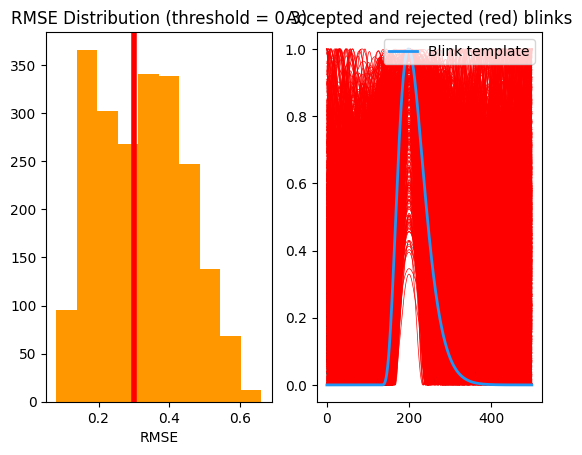

In [18]:
## Усталость

@dataclasses.dataclass(frozen=True)
class EOGSettings:
    eeg_first_background_duration_secs: int
    fir_filter_low_freq_hz: float
    fir_filter_high_freq_hz: float
    ica_method: str
    ica_components_number: int
    ica_random_state: int
    ica_threshold: float
    ica_channels: list[str]
    eog_rolling_window_size: float
    eog_vertical_limit_enough_to_detect_inverted_signal: int
    eog_peaks_threshold: float


@dataclasses.dataclass(frozen=True)
class FatigueSettings:
    eog_settings: EOGSettings
    fatigue_ref_min: float
    fatigue_ref_max: float

@dataclasses.dataclass(frozen=True)
class Fatigue:
    base_abs: float
    final_abs: float
    accumulated_abs: float

    base_percent: float
    final_percent: float
    accumulated_percent: float

    base_percent_normalized: float
    final_percent_normalized: float
    accumulated_percent_normalized: float

ECF_FATIGUE = {
    "EOG": {
        "eeg_first_background_duration_secs": 60,
        "fir_filter_low_freq_hz": 1.0,
        "fir_filter_high_freq_hz": 40.0,
        "ica_method": "fastica",
        "ica_components_number": 30,
        "ica_random_state": 97,
        "ica_threshold": 3.3,
        "ica_channels": ["Fp1", "Fp2"],
        "eog_rolling_window_size": 5.0,
        "eog_vertical_limit_enough_to_detect_inverted_signal": 10_000,
        "eog_peaks_threshold": 0.3,
    },
    "FATIGUE": {
        "fatigue_ref_min": 4.1,
        "fatigue_ref_max": 6.4,
    },
}

@dataclasses.dataclass
class BackgroundTimestamp:
    start: int | float
    end: int | float

fatigue_settings = FatigueSettings(
    **ECF_FATIGUE["FATIGUE"],
    eog_settings=EOGSettings(**ECF_FATIGUE["EOG"])
)

streams_for_analysis = [{"type": "Samples"}, {"type": "EEG"}]
try:
    streams_data = pyxdf.load_xdf('/content/drive/MyDrive/edf_process/' + filename + '.xdf')[0]
except FileNotFoundError as err:
    raise ECFApplicationError from err

try:
    samples_stream, _, eeg_stream = get_streams(streams_data)
except (UnsupportedStreamError, StreamsNotFoundError) as err:
    raise ECFApplicationError from err

samples_df = samples_stream.to_dataframe()
precision = 10**4
first_marker_timestamp = samples_df.iloc[0]["timestamp"] / precision
last_marker_timestamp = samples_df.iloc[-1]["timestamp"] / precision
start_eeg_time_lsl = eeg_stream.to_dataframe().iloc[0]["timestamp"] / precision

background_timestamp = BackgroundTimestamp(
    start=first_marker_timestamp - start_eeg_time_lsl,
    end=(
        last_marker_timestamp
        + fatigue_settings.eog_settings.eeg_first_background_duration_secs
    )
    - start_eeg_time_lsl,
)

raw_eeg = eeg_stream.to_raw()

fatigue = FatigueCalculationService(
    raw_eeg=raw_eeg,
    background_timestamp=background_timestamp,
    settings=fatigue_settings,
).calculate_fatigue()

print(fatigue)

In [28]:
eeg_data, eeg_times = raw_eeg.get_data(return_times=True)
print(raw_eeg.ch_names)
print('число отчетов во временном ряду:',len(eeg_times))
# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 10)[0][0]
t_index_end = np.where(eeg_times > 290)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

y = eeg_data[6, t_index_begin:t_index_end]

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'Iz', 'x_dir', 'y_dir', 'z_dir', 'MkIdx']
число отчетов во временном ряду: 2669797


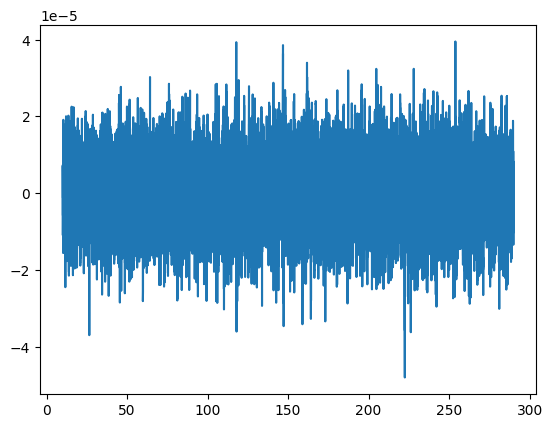

In [29]:
plt.plot(t,y)